In [28]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, mean_squared_error, recall_score
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold


import warnings
warnings.filterwarnings('ignore')

## Dataset

In [29]:
df = pd.read_csv('https://raw.githubusercontent.com/EmilyBederov/Intro-To-ML/main/creditcardcsvpresentML.csv')
df

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,NaN,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,NaN,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,NaN,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,NaN,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
3070,6661273532,NaN,500.0,11000.0,Y,0,N,N,754,585.0,7,N
3071,6661273532,NaN,800.0,0.0,Y,0,N,N,754,585.0,7,N
3072,6661273533,NaN,800.0,20800.0,Y,0,N,N,754,585.0,7,N
3073,6661273532,NaN,1500.0,12000.0,Y,0,Y,Y,754,585.0,7,N


Some info about the data:
* 
*
*
*
* now lets explore our features

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Merchant_id                     3075 non-null   int64  
 1   Transaction date                0 non-null      float64
 2   Average Amount/transaction/day  3075 non-null   float64
 3   Transaction_amount              3075 non-null   float64
 4   Is declined                     3075 non-null   object 
 5   Total Number of declines/day    3075 non-null   int64  
 6   isForeignTransaction            3075 non-null   object 
 7   isHighRiskCountry               3075 non-null   object 
 8   Daily_chargeback_avg_amt        3075 non-null   int64  
 9   6_month_avg_chbk_amt            3075 non-null   float64
 10  6-month_chbk_freq               3075 non-null   int64  
 11  isFradulent                     3075 non-null   object 
dtypes: float64(4), int64(4), object(4)

In [31]:
#before mapping our features to numbers lets check for unique varibles
print("Unique values before mapping:")
print("Is declined:", df['Is declined'].unique())
print("isForeignTransaction:", df['isForeignTransaction'].unique())
print("isHighRiskCountry:", df['isHighRiskCountry'].unique())
print("isFradulent:", df['isFradulent'].unique())

Unique values before mapping:
Is declined: ['N' 'Y']
isForeignTransaction: ['Y' 'N']
isHighRiskCountry: ['Y' 'N']
isFradulent: ['Y' 'N']


### we see that in our numerical features, there arent 'non numerical' values. now lets convert the categorical data to numerical data.

In [32]:
# Mapping for binary categorical variables
mapping = {'Y': 1, 'N': 0}

df['Is declined'] = df['Is declined'].map(mapping)
df['isForeignTransaction'] = df['isForeignTransaction'].map(mapping)
df['isHighRiskCountry'] = df['isHighRiskCountry'].map(mapping)
df['isFradulent'] = df['isFradulent'].map(mapping)

df

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,0,5,1,1,0,0.0,0,1
1,3160040998,NaN,100.0,4300.0,0,5,1,1,0,0.0,0,1
2,3160041896,NaN,185.5,4823.0,1,5,0,0,0,0.0,0,1
3,3160141996,NaN,185.5,5008.5,1,8,0,0,0,0.0,0,1
4,3160241992,NaN,500.0,26000.0,0,0,1,1,800,677.2,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3070,6661273532,NaN,500.0,11000.0,1,0,0,0,754,585.0,7,0
3071,6661273532,NaN,800.0,0.0,1,0,0,0,754,585.0,7,0
3072,6661273533,NaN,800.0,20800.0,1,0,0,0,754,585.0,7,0
3073,6661273532,NaN,1500.0,12000.0,1,0,1,1,754,585.0,7,0


now lets move on with exploring the data, show some plots, and statostical analysis

In [33]:
df.describe()

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
count,3.075000e+03,0.0,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000
mean,5.026634e+09,NaN,515.026556,9876.399210,0.018537,0.957398,0.229593,0.066667,55.737561,40.022407,0.391870,0.145691
std,9.870778e+08,NaN,291.906978,10135.331016,0.134903,2.192391,0.420640,0.249484,206.634779,155.968840,1.548479,0.352854
min,3.160041e+09,NaN,4.011527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.170814e+09,NaN,269.788047,2408.781147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.025578e+09,NaN,502.549575,6698.891856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.889625e+09,NaN,765.272803,14422.568935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.665906e+09,NaN,2000.000000,108000.000000,1.000000,20.000000,1.000000,1.000000,998.000000,998.000000,9.000000,1.000000


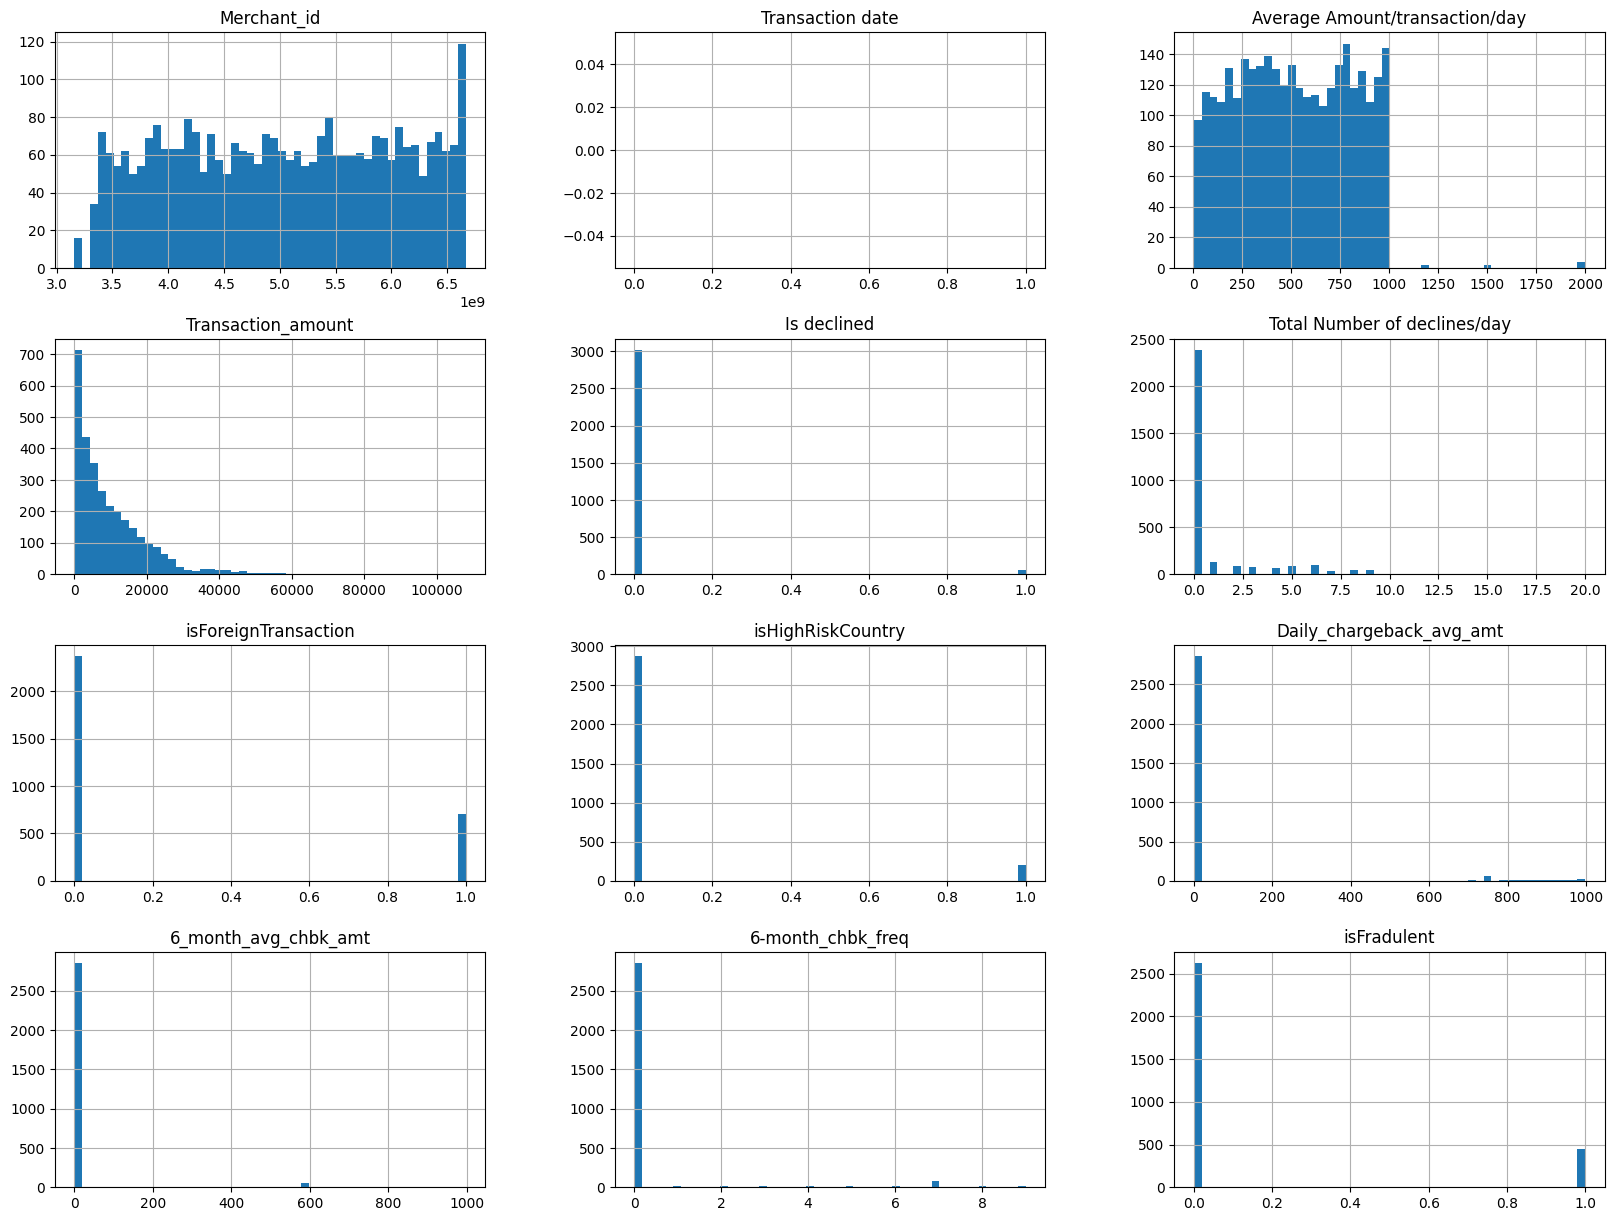

In [34]:
_ = df.hist(bins=50, figsize=(20,15))

* the data apears to dist .............

In [35]:
df

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,0,5,1,1,0,0.0,0,1
1,3160040998,NaN,100.0,4300.0,0,5,1,1,0,0.0,0,1
2,3160041896,NaN,185.5,4823.0,1,5,0,0,0,0.0,0,1
3,3160141996,NaN,185.5,5008.5,1,8,0,0,0,0.0,0,1
4,3160241992,NaN,500.0,26000.0,0,0,1,1,800,677.2,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3070,6661273532,NaN,500.0,11000.0,1,0,0,0,754,585.0,7,0
3071,6661273532,NaN,800.0,0.0,1,0,0,0,754,585.0,7,0
3072,6661273533,NaN,800.0,20800.0,1,0,0,0,754,585.0,7,0
3073,6661273532,NaN,1500.0,12000.0,1,0,1,1,754,585.0,7,0


moving on to
### Preprocessing:
* searching for duplicates
* Handaling missing values
* Encoding needed data
* Binning features
* Combinning features
* Removing Irrelavent features

checking for duplicate rows:

In [36]:
# Check for duplicate rows in the entire DataFrame
duplicates = df.duplicated(keep=False)

# Filter out the duplicate rows
duplicate_rows = df[duplicates]

# Display the shape and the duplicate rows
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
print("Duplicate rows:")
print(duplicate_rows)

Number of duplicate rows: 0
Duplicate rows:
Empty DataFrame
Columns: [Merchant_id, Transaction date, Average Amount/transaction/day, Transaction_amount, Is declined, Total Number of declines/day, isForeignTransaction, isHighRiskCountry, Daily_chargeback_avg_amt, 6_month_avg_chbk_amt, 6-month_chbk_freq, isFradulent]
Index: []


now, were moving on..

In [37]:
# missing values
missing_values_count = df.isnull().sum()
print(missing_values_count)

Merchant_id                          0
Transaction date                  3075
Average Amount/transaction/day       0
Transaction_amount                   0
Is declined                          0
Total Number of declines/day         0
isForeignTransaction                 0
isHighRiskCountry                    0
Daily_chargeback_avg_amt             0
6_month_avg_chbk_amt                 0
6-month_chbk_freq                    0
isFradulent                          0
dtype: int64


we will eliminate 'Transaction date' - Since everything is missing
- also we will eliminate id, doesnt have any affect on the fraud detaction

In [38]:
df = df.drop(columns='Transaction date', axis=1)
df = df.drop(columns='Merchant_id', axis=1)

lets dig dipper, lets search for negative values which are obviously are missing values. and as we said this step is done only on our train dataset.

In [39]:
def check_values(df, columns):
   
    results = {}
    for col in columns:
        negative_values_count = (df[col] < 0).sum()
        results[col] = {
            'negative_values_count': negative_values_count
        }
    return results

# List of columns to check
columns_to_check = ['Average Amount/transaction/day', 'Transaction_amount', 'Is declined', 'Total Number of declines/day', 'isForeignTransaction', 'isHighRiskCountry','Daily_chargeback_avg_amt', '6_month_avg_chbk_amt', '6-month_chbk_freq', 'isFradulent']

values_check = check_values(df, columns_to_check)
print("Negative val in training Dataset:")
for col, checks in values_check.items():
    print(f"Column: {col} - Negative Values: {checks['negative_values_count']}")

Negative val in training Dataset:
Column: Average Amount/transaction/day - Negative Values: 0
Column: Transaction_amount - Negative Values: 0
Column: Is declined - Negative Values: 0
Column: Total Number of declines/day - Negative Values: 0
Column: isForeignTransaction - Negative Values: 0
Column: isHighRiskCountry - Negative Values: 0
Column: Daily_chargeback_avg_amt - Negative Values: 0
Column: 6_month_avg_chbk_amt - Negative Values: 0
Column: 6-month_chbk_freq - Negative Values: 0
Column: isFradulent - Negative Values: 0


we can move forward -> lets handle outliers.

In [40]:
def detect_outliers_iqr(df):
    outlier_dict = {}  # To store outliers and their counts for each column
    for column in df.columns:  
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        IQR = q3 - q1
        lower_bound = q1 - 1.5 * IQR
        upper_bound = q3 + 1.5 * IQR

        # Identifying outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        if not outliers.empty:
            outlier_dict[column] = {'outliers': outliers.tolist(), 'count': len(outliers)}
        else:
            outlier_dict[column] = {'outliers': "No outliers detected", 'count': 0}

    return outlier_dict

outliers_dict = detect_outliers_iqr(df)

print("Number of Outliers from IQR method:")
for column, info in outliers_dict.items():
    print(f"{column}: {info['count']}")

for column, info in outliers_dict.items():
        print(f"Outliers from IQR method for {column}: {info}")

Number of Outliers from IQR method:
Average Amount/transaction/day: 4
Transaction_amount: 113
Is declined: 57
Total Number of declines/day: 691
isForeignTransaction: 706
isHighRiskCountry: 205
Daily_chargeback_avg_amt: 218
6_month_avg_chbk_amt: 218
6-month_chbk_freq: 218
isFradulent: 448
Outliers from IQR method for Average Amount/transaction/day: {'outliers': [2000.0, 2000.0, 2000.0, 2000.0], 'count': 4}
Outliers from IQR method for Transaction_amount: {'outliers': [39858.59905, 42652.3736, 36692.35941, 44531.9843, 38076.65874, 43444.04819, 33359.44532, 40454.5334, 37830.3206, 53116.92799, 39016.11702, 46789.84691, 43533.83346, 46067.5262, 52304.76611, 37403.54317, 44344.78686, 44646.97264, 46974.26042, 35941.06769, 37414.54867, 41654.95372, 33170.20285, 46035.33636, 39774.31547, 39487.05127, 41671.40658, 50848.20441, 32507.86462, 44113.33625, 35081.58671, 47239.55311, 33240.30626, 50338.30212, 40080.00063, 36363.98968, 42160.82011, 51641.84407, 34041.237, 56354.53925, 37431.79458, 33

In our categorical data, there is an extreme number of outliers, lets plot our data, for better understanding

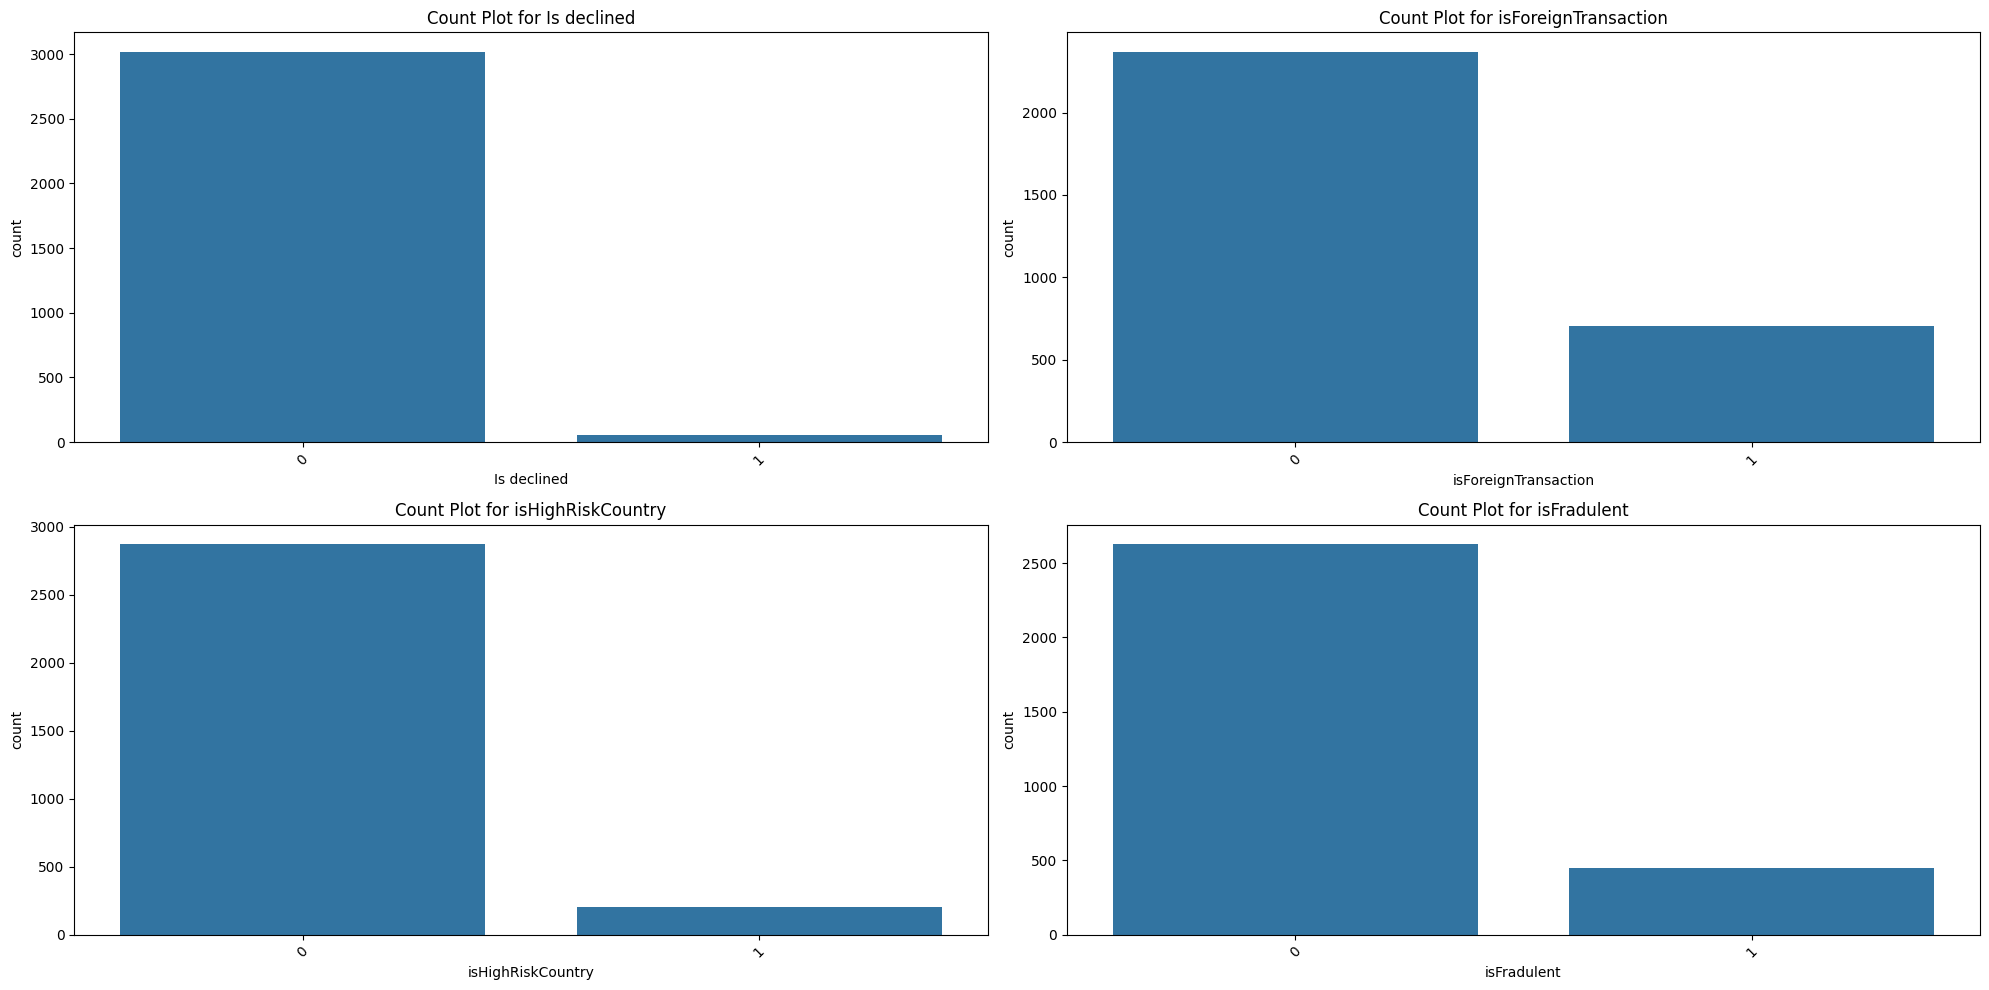

In [41]:
categorical_columns = ['Is declined', 'isForeignTransaction', 'isHighRiskCountry', 'isFradulent']

# Set up the matplotlib figure
plt.figure(figsize=(20, 10))

# Generate count plots for each categorical column
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)  # Adjust the subplot grid size if you have more/less categorical columns
    sns.countplot(data=df, x=col)
    plt.title(f'Count Plot for {col}')
    plt.xticks(rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [42]:
## Explanation why we cant remove this "outleirs"

before removing outliers, we need to understand whther or not it is reasonible' lets again look at our data

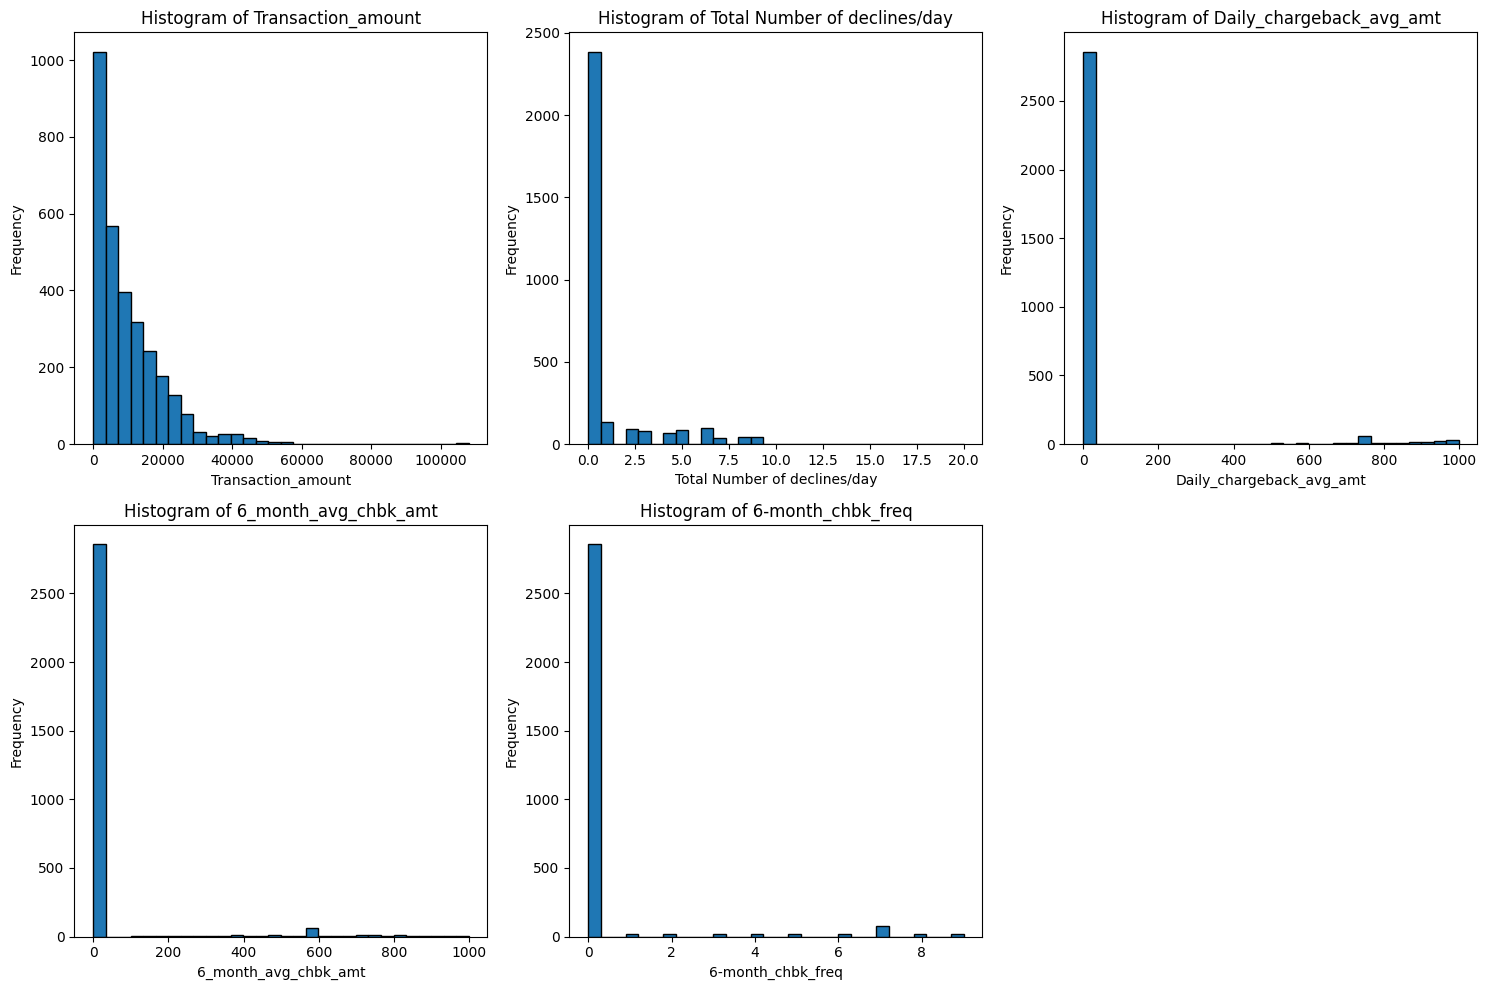

In [43]:
numerical_columns = [
    'Transaction_amount',
    'Total Number of declines/day',
    'Daily_chargeback_avg_amt',
    '6_month_avg_chbk_amt',
    '6-month_chbk_freq'
]

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Generate histograms for each numerical column
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  # Adjust the subplot grid size based on the number of columns
    plt.hist(df[col].dropna(), bins=30, edgecolor='k')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

in our dataset, we cant remove the outliers, because it is what we actually care about the most -> the fraud detection.
We want to detect frauds using anomaly points, thus, we wont handle the outliers right now.

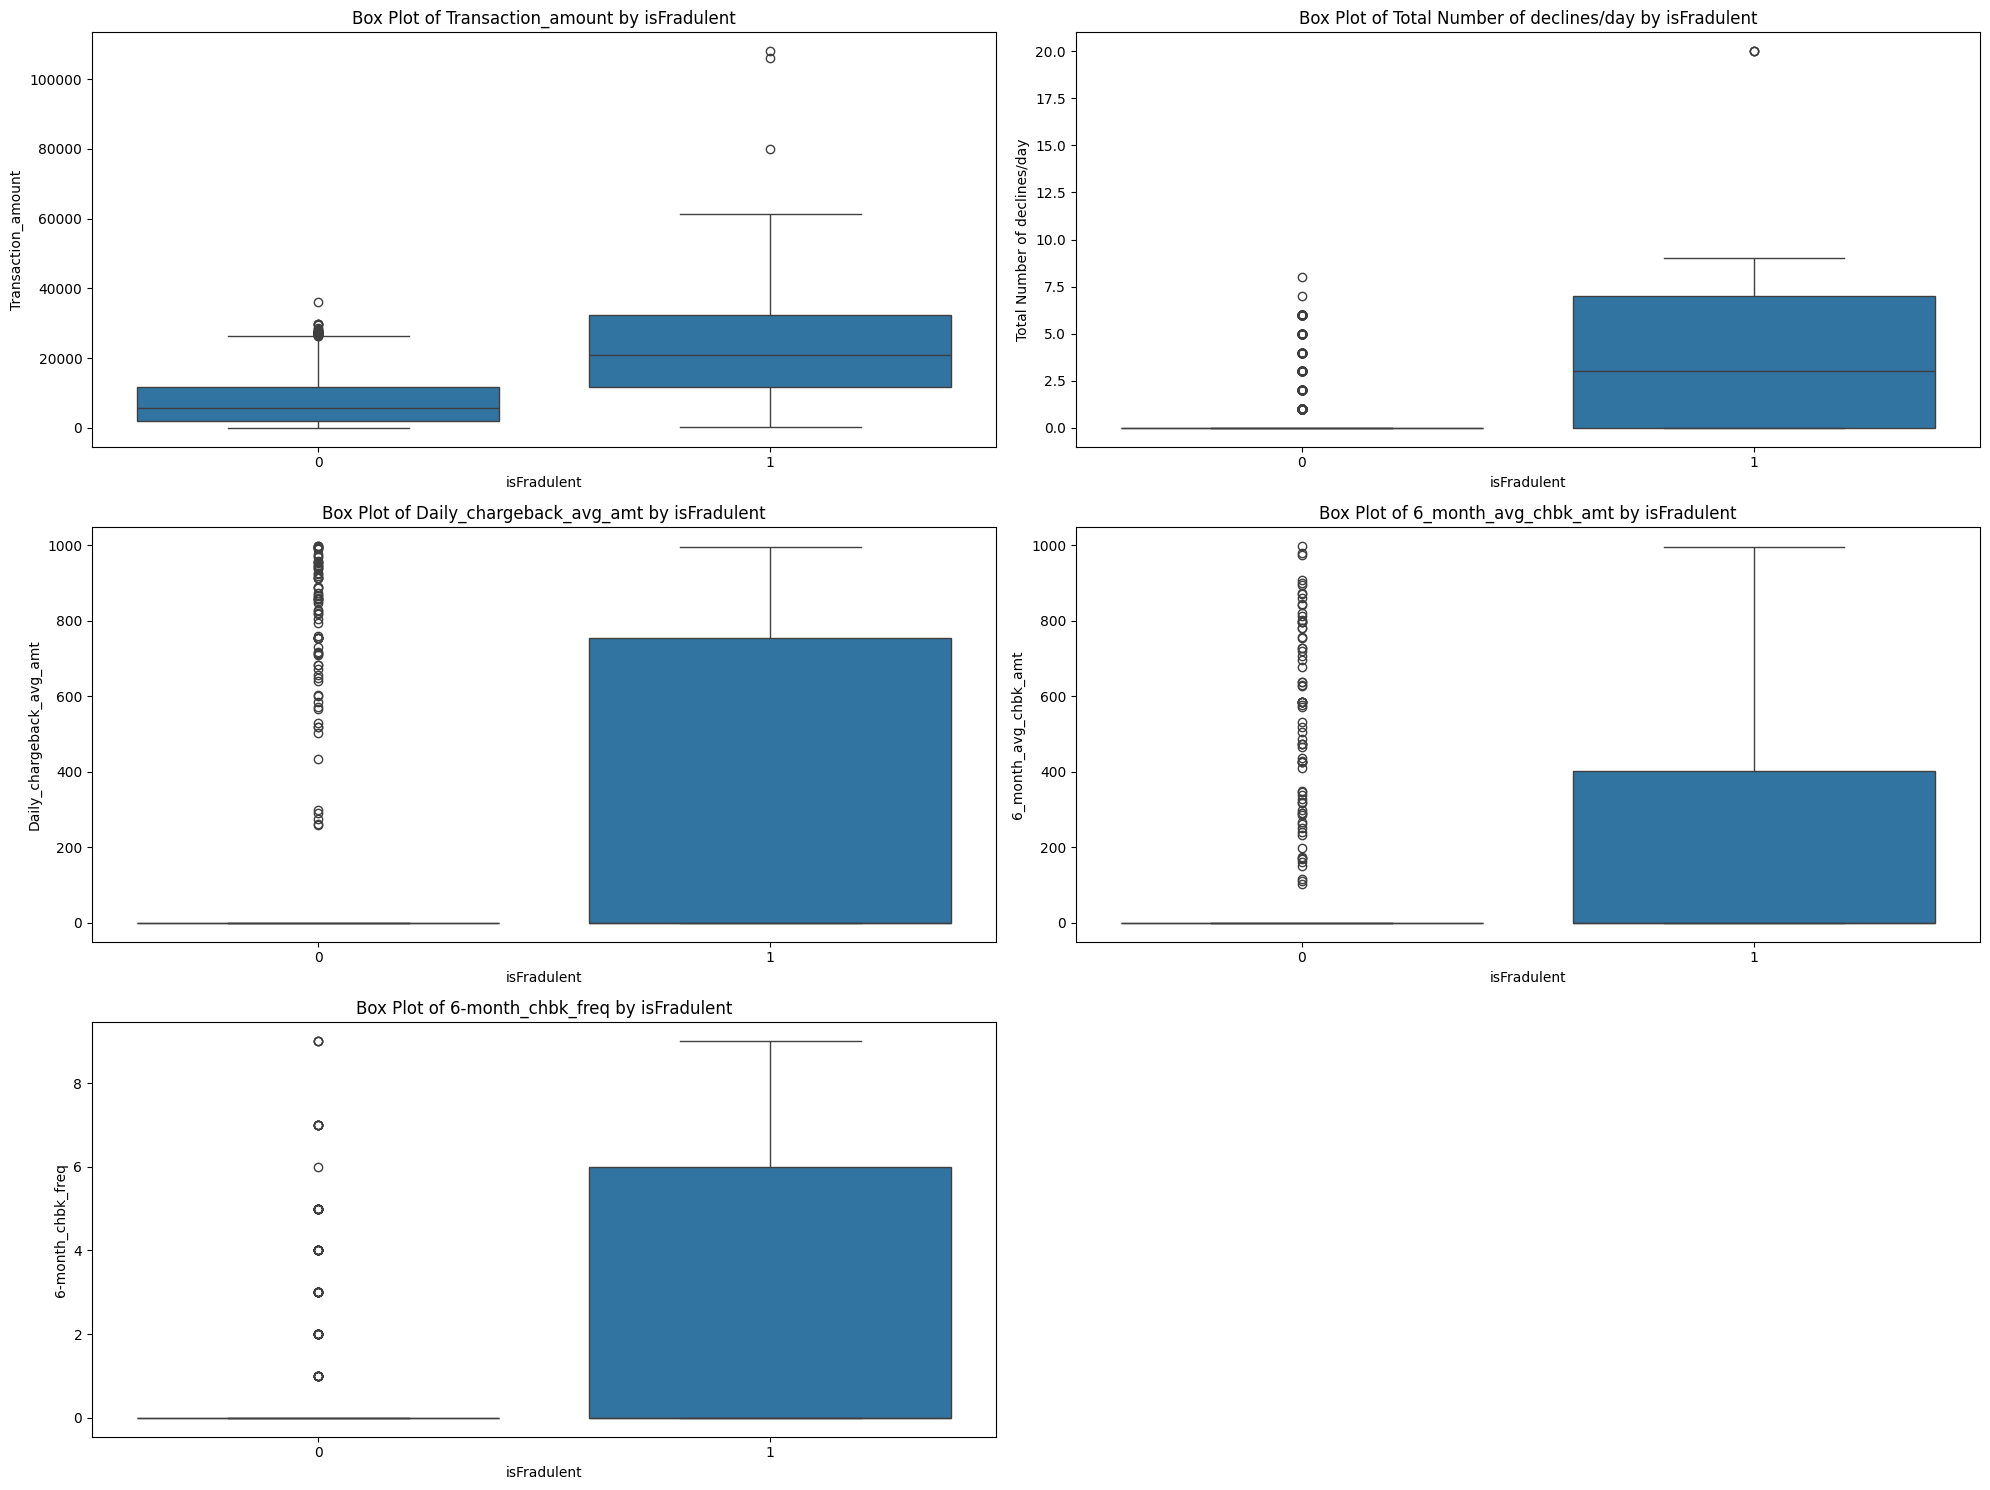

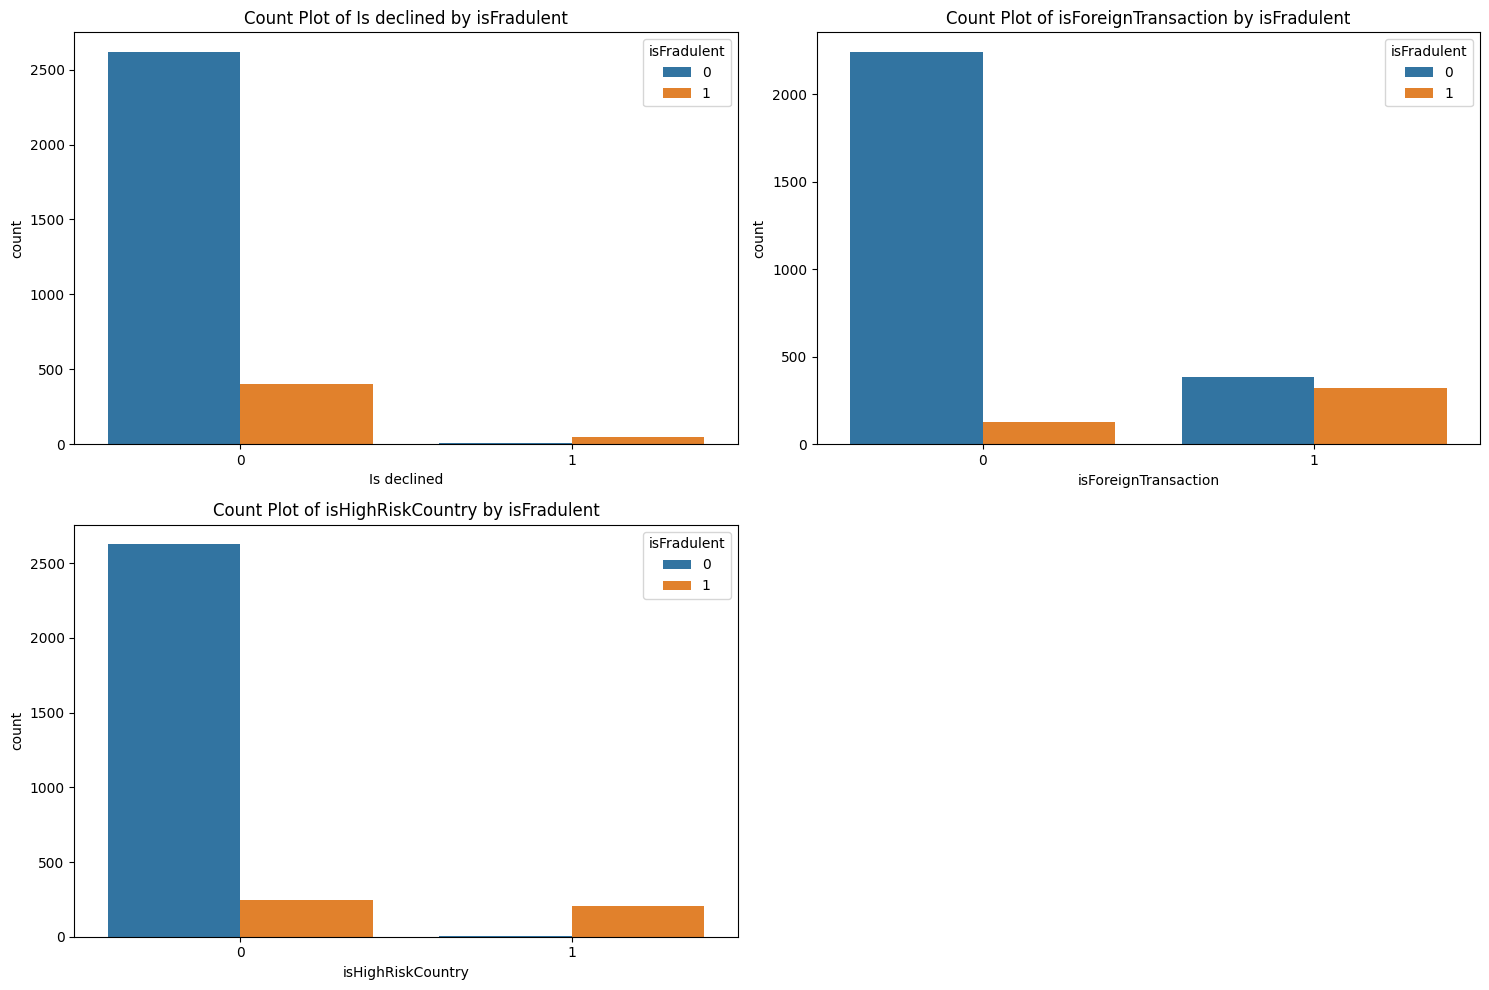

In [44]:
numerical_columns = [
    'Transaction_amount',
    'Total Number of declines/day',
    'Daily_chargeback_avg_amt',
    '6_month_avg_chbk_amt',
    '6-month_chbk_freq'
]

categorical_columns = ['Is declined', 'isForeignTransaction', 'isHighRiskCountry']

# Plot numerical features
plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x='isFradulent', y=col)
    plt.title(f'Box Plot of {col} by isFradulent')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Plot categorical features
plt.figure(figsize=(15, 10))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=col, hue='isFradulent')
    plt.title(f'Count Plot of {col} by isFradulent')
    plt.legend(title='isFradulent', loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

1.	Transaction Amount by isFradulent:
* Observations:
	-	Non-fraudulent transactions (0) tend to have lower transaction amounts with a lower range.
	-	Fraudulent transactions (1) tend to have higher transaction amounts with a wider range and more outliers.
	-	There are several high-value outliers in fraudulent transactions.
2. Total Number of Declines/Day by isFradulent:
* Observations:
	-	Non-fraudulent transactions (0) typically have fewer declines per day.
	-	Fraudulent transactions (1) have higher declines per day, suggesting a pattern of frequent declines being associated with fraud.
3. Daily Chargeback Average Amount by isFradulent:
* Observations:
	-	Non-fraudulent transactions (0) have a low average daily chargeback amount, with many values clustering around zero.
	-	Fraudulent transactions (1) have significantly higher average daily chargeback amounts, indicating a strong association with chargebacks.
4. 6-Month Average Chargeback Amount by isFradulent:
* Observations:
	-	Non-fraudulent transactions (0) have lower 6-month average chargeback amounts.
	-	Fraudulent transactions (1) have higher 6-month average chargeback amounts, indicating that fraud is associated with higher chargeback activity over a longer period.
5. 6-Month Chargeback Frequency by isFradulent:
* Observations:
	-	Non-fraudulent transactions (0) have lower chargeback frequencies.
	-	Fraudulent transactions (1) have significantly higher chargeback frequencies, suggesting that fraudulent activity often involves frequent chargebacks.


### Fraudulent Transactions: Generally associated with higher transaction amounts, more declines per day, higher average daily and 6-month chargeback amounts, and higher chargeback frequencies.
* Non-Fraudulent Transactions: Tend to have lower values in these metrics, with fewer declines, lower chargeback amounts, and lower chargeback frequencies.
* These insights can help in identifying patterns and characteristics associated with fraudulent transactions, which can be useful for building models to predict and detect fraud.


## Now we will split the data to 
* Train
* Test
* Validation
#### firstly, we will use stratifeid shuffle and shuffle the data

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

now, as for why we chose to split after performing EDA:

1. Ensuring Data Integrity and Consistency

	•	Data Cleaning: Before splitting the data, you need to handle missing values, remove duplicates, and correct any inconsistencies in the dataset. Performing these steps ensures that the data fed into both the training and testing sets is clean and of high quality.
	•	Uniformity: Data cleaning ensures that both the training and testing sets have the same structure and format, which is essential for building and evaluating the model effectively.

2. Preventing Data Leakage

	•	Data Leakage: If the train/test split is performed before data cleaning, there’s a risk that information from the test set could inadvertently influence the training set during the cleaning process. This can lead to overly optimistic performance estimates and poor generalization to new data.
	•	Isolation: By splitting the data after cleaning, you ensure that the test set remains a true representation of unseen data, preserving its integrity for unbiased model evaluation.

3. Ensuring Comprehensive EDA

	•	Exploratory Data Analysis: EDA involves understanding the data distribution, identifying relationships between variables, and uncovering patterns. Performing EDA on the entire dataset ensures that you have a comprehensive understanding of the data before any modifications.
	•	Informed Cleaning: Insights gained from EDA guide the data cleaning process. For example, you might identify outliers or anomalies that need to be addressed before splitting the data.

4. Maintaining the Distribution of Data

	•	Stratified Splitting: After EDA, you might decide to use stratified sampling to ensure that the train and test sets have the same distribution of key variables (e.g., target classes). This is particularly important for imbalanced datasets.
	•	Balanced Evaluation: Maintaining the distribution ensures that both the training and testing sets are representative of the overall dataset, leading to more reliable model evaluation.

5. Efficient Use of Resources

	•	Resource Allocation: Cleaning and preparing data can be resource-intensive. Performing these tasks once on the entire dataset, rather than separately on training and testing sets, is more efficient.
	•	Avoiding Redundancy: By conducting EDA and cleaning on the entire dataset, you avoid redundant processing and ensure that both sets benefit from the same cleaning procedures.

6. Consistent Feature Engineering

	•	Feature Engineering: EDA often leads to feature engineering decisions, such as creating new variables or transforming existing ones. Performing these steps on the entire dataset ensures consistency in the features used by the model.
	•	Robust Model Development: Consistent features across training and testing sets ensure that the model can leverage the same information during both training and evaluation phases.

Summary

Constructing the train/test split after EDA and data cleaning ensures that the data used for training and testing is of high quality, free from inconsistencies, and reflective of the actual data distribution. This approach minimizes the risk of data leakage, ensures comprehensive analysis and cleaning, and leads to more reliable and unbiased model evaluation.

In [46]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# Split the train set into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

### We will use 4 models of unsupervised learning:
1. Isolation forest
2. Neural Networks with LSTM autoencoders
3. Local Outlier Factor
4. Gaussian mixture
   
We want to find the pattern of fraudulent purchases. Every person generally has certain patterns of purchases which they make. If there is an outlier to this pattern the bank needs to detect it in order to analyze it for potential fraud. In those models we will find outliers assuming frauds will be expressed as outliers.

# Metrics

In [47]:
# Create a results dataframe to store and later compare results
results = pd.DataFrame()
results['Metrics'] = ['True Negatives', 'False Negatives', 'False Positives', 'True Positives', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Support']
resultsCrossVal = {
    'Isolation Forest': [],
    'LOF (Novelty Detection)': [],
    'Gaussian Mixture Model': []
}

def get_metrics(labels, pred_labels):
    conf_matrix = np.asarray(confusion_matrix(labels, pred_labels))
    metrics = np.concatenate(([accuracy_score(labels, pred_labels)], precision_recall_fscore_support(labels, pred_labels, average='binary')))
    return np.concatenate((conf_matrix.reshape(-1),metrics))

def fit_model(input_data, model_fn, model_args=None, threshold=None, labels=None):
    return model_fn(input_data, model_args, threshold, labels)

def predict_model(input_data, model, predict_fn, threshold=None):
    return predict_fn(input_data, model, threshold)

In [48]:
X = train_df.drop(columns=['isFradulent'])
y = train_df['isFradulent']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Isolation Forest

In [49]:
def fit_isolation_forest(input_data, args=None, threshold=None, labels=None):
    if threshold == None:
        model = IsolationForest()
    else:
        model = IsolationForest(contamination=threshold)
    
    model.fit(input_data)

    return model

def predict_isolation_forest(input_data, model, threshold=None):
    y_pred = model.predict(input_data)
    y_pred = [1 if pred == -1 else 0 for pred in y_pred]

    return y_pred

In [50]:
if_model = fit_model(X_train, fit_isolation_forest, None)

y_pred_test = predict_model(X_test, if_model, predict_isolation_forest)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[317  20]
 [  5  52]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       337
           1       0.72      0.91      0.81        57

    accuracy                           0.94       394
   macro avg       0.85      0.93      0.88       394
weighted avg       0.95      0.94      0.94       394



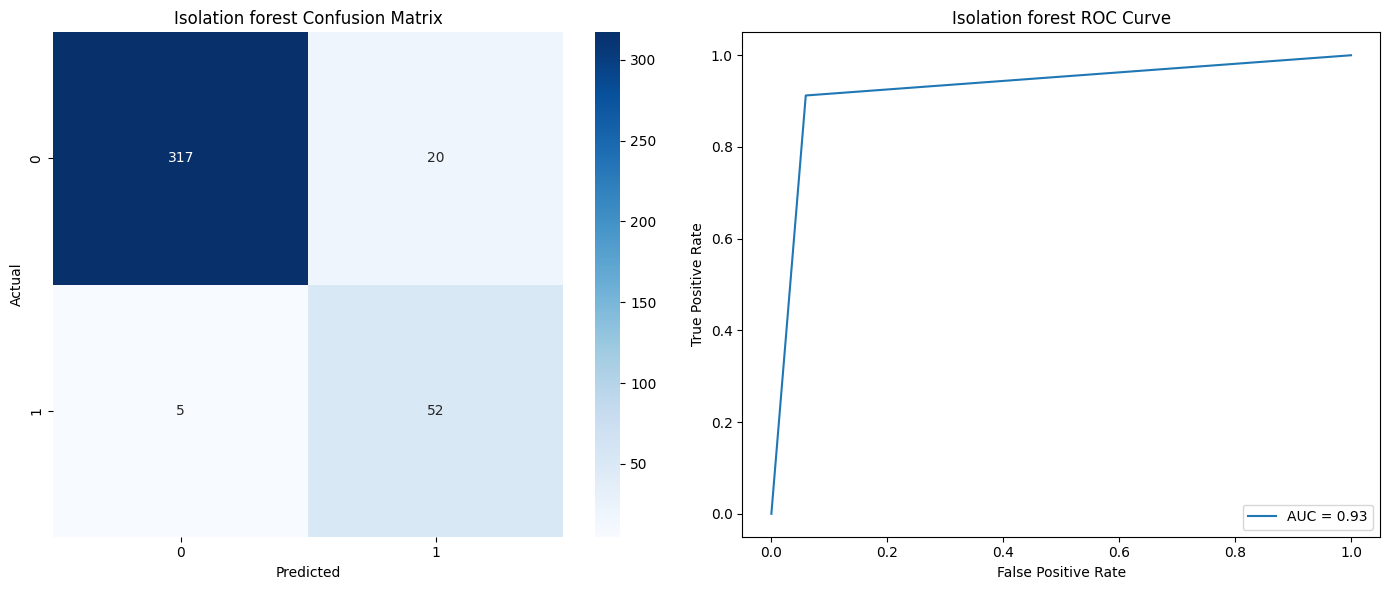

In [51]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test, y_pred_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
auc = roc_auc_score(y_test,y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Isolation forest Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
ax[1].set_title('Isolation forest ROC Curve')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [52]:
results['Isolation Forest'] = get_metrics(y_test, y_pred_test)

# Cross Validation

In [59]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize Isolation Forest
    model = IsolationForest(random_state=42)
    
    # Fit the model on the training data
    model.fit(X_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Convert predictions from {-1, 1} to {0, 1}
    y_pred = np.where(y_pred == -1, 1, 0)
    
    # Evaluate the model
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

# Print evaluation metrics
print(f'Average Accuracy: {average_accuracy:.2f}')
print(f'Average Precision: {average_precision:.2f}')
print(f'Average Recall: {average_recall:.2f}')
print(f'Average F1 Score: {average_f1:.2f}')

Average Accuracy: 0.95
Average Precision: 0.77
Average Recall: 0.94
Average F1 Score: 0.85


In [60]:
resultsCrossVal['Isolation Forest'].append(get_metrics(y_test, y_pred))

# Local Outlier Factor

#### Dataset Distribution (Outlier and Novelty detection)

We have to distribute the datasets in two different ways in order to perform both outlier and novelty detection. 

For **Outlier Detection** dataset we are going to concat train and test set since this methods run predictions over the same data. 

For **Novelty Detection** dataset we need to remove all fraud samples from the training set and put them on the test set.

In [61]:
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_test = pd.concat([X_test, y_test], axis=1)

# Outlier-detection Dataset
X_out_train = pd.concat([Xy_train, Xy_test], axis=0)
y_out_train = pd.DataFrame(X_out_train['isFradulent'])
X_out_train.drop('isFradulent', axis='columns', inplace= True)

# Novelty-detection Dataset
X_nov_train = Xy_train[Xy_train['isFradulent'] == 0].copy()
X_nov_train.drop('isFradulent', axis='columns', inplace= True)
X_nov_train_val = Xy_train.drop('isFradulent', axis='columns', inplace= False)
y_nov_train_val = y_train

print('X_train', str(len(X_train)))
print('X_nov_train', str(len(X_nov_train)))
print('X_out_train', str(len(X_out_train)))
print('y_out_train', str(len(y_out_train)))
print('X_test', str(len(X_test)))
print('y_test', str(len(y_test)))

X_train 1575
X_nov_train 1363
X_out_train 1968
y_out_train 1968
X_test 393
y_test 393


### Training

In [62]:
# Calculate outlier_fraction value to be sent as contamination parameter
no_fraud = len(y_out_train[y_out_train['isFradulent'] == 1])
no_valid = len(y_out_train) - no_fraud

outlier_fraction = no_fraud/float(no_valid)

print('X_train len: ',len(X_out_train))
print('y_train len: ',len(y_out_train))
print('total: ',no_fraud+no_valid)
print('no_fraud: ',no_fraud)
print('no_valid: ',no_valid)
print('Outlier Fraction: ',outlier_fraction)

X_train len:  1968
y_train len:  1968
total:  1968
no_fraud:  267
no_valid:  1701
Outlier Fraction:  0.15696649029982362


In [63]:
lof_model = LocalOutlierFactor(n_neighbors = 20,contamination = outlier_fraction, novelty=False)

y_prediction1 = lof_model.fit_predict(X_out_train) # Fitting the model.

y_prediction1[y_prediction1 == 1] = 0 # Valid transactions are labelled as 0.
y_prediction1[y_prediction1 == -1] = 1 # Fraudulent transactions are labelled as 1.

print('CLASSIFICATION RESULTS')
print(classification_report(y_out_train,y_prediction1))

CLASSIFICATION RESULTS
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1701
           1       0.39      0.45      0.42       267

    accuracy                           0.83      1968
   macro avg       0.65      0.67      0.66      1968
weighted avg       0.84      0.83      0.84      1968



# Novelty Detection

In [64]:
def fit_local_outlier_factor(input_data, args, threshold=None, labels=None):
    # Combine input data and labels into a single DataFrame
    Xy_input = pd.concat([input_data, labels], axis=1)

    # Select rows where 'isFradulent' is 0 (non-fraudulent transactions)
    X_no_fraud = Xy_input[Xy_input['isFradulent'] == 0].copy()

    # Drop the 'isFradulent' column as it is not needed for the model
    X_no_fraud.drop('isFradulent', axis='columns', inplace=True)

    # Calculate the outlier fraction if threshold is not provided
    if threshold is None:
        no_fraud = len(labels[labels == 1])
        no_valid = len(labels) - no_fraud
        outlier_fraction = no_fraud / float(no_valid)
        model = LocalOutlierFactor(n_neighbors=args[0], contamination=outlier_fraction, novelty=True)
    else:
        model = LocalOutlierFactor(n_neighbors=args[0], contamination=threshold, novelty=True)
    
    # Fit the model on the non-fraudulent data
    model.fit(X_no_fraud)

    return model

def predict_local_outlier_factor(input_data, model, threshold=None):
    y_prediction = model.predict(input_data)
    y_prediction[y_prediction == 1] = 0  # Valid transactions are labelled as 0.
    y_prediction[y_prediction == -1] = 1  # Fraudulent transactions are labelled as 1.

    return y_prediction

In [65]:
def fit_model(input_data, model_fn, model_args=None, threshold=None, labels=None):
    return model_fn(input_data, model_args, threshold, labels)

def predict_model(input_data, model, predict_fn):
    return predict_fn(input_data, model)

In [66]:
lof_model = fit_local_outlier_factor(X_train, [20], labels=y_train)
y_pred_test = predict_local_outlier_factor(X_test, lof_model)

print('CONFUSION MATRIX:\n', confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[286  52]
 [ 16  39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.85      0.89       338
           1       0.43      0.71      0.53        55

    accuracy                           0.83       393
   macro avg       0.69      0.78      0.71       393
weighted avg       0.87      0.83      0.84       393



**Note:** We will only use the Novelty Detection results, since we want to compare results over the same test data and we only can run prediction with outlier detection over the training data.

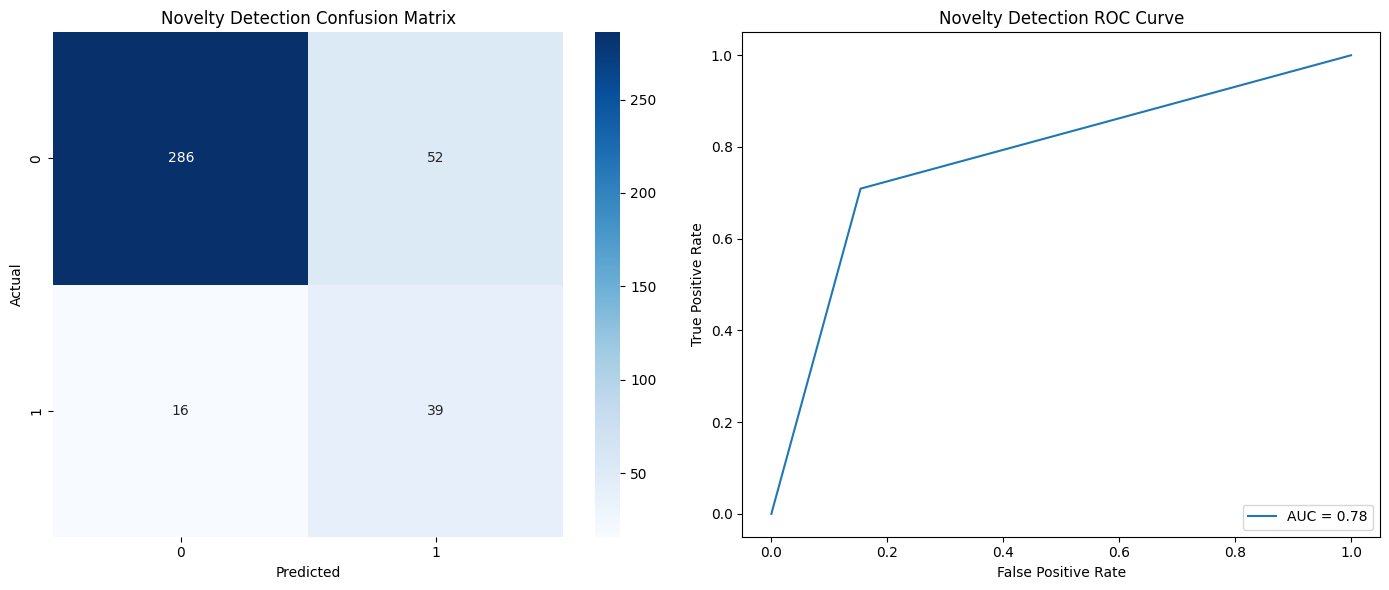

In [67]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test, y_pred_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
auc = roc_auc_score(y_test,y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Novelty Detection Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
ax[1].set_title('Novelty Detection ROC Curve')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [68]:
results['LOF Novelty Detection'] = get_metrics(y_test,y_pred_test)

## Cross validation

In [69]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize Local Outlier Factor with novelty=True for novelty detection
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
    
    # Fit the model on the training data
    lof.fit(X_train)
    
    # Predict on the test data
    y_pred = lof.predict(X_test)
    
    # Convert predictions from {-1, 1} to {0, 1}
    y_pred = np.where(y_pred == -1, 1, 0)
    
    # Evaluate the model
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

# Print evaluation metrics
print(f'Average Accuracy: {average_accuracy:.2f}')
print(f'Average Precision: {average_precision:.2f}')
print(f'Average Recall: {average_recall:.2f}')
print(f'Average F1 Score: {average_f1:.2f}')

Average Accuracy: 0.85
Average Precision: 0.44
Average Recall: 0.34
Average F1 Score: 0.38


In [70]:
resultsCrossVal['LOF (Novelty Detection)'].append(get_metrics(y_test, y_pred))

# Gaussian Mixture

In [71]:
def fit_gaussian_mixture(input_data, args=None, threshold=None, labels=None):
    if threshold == None:
        model = GaussianMixture(n_components=2)
    else:
        model = GaussianMixture(n_components=2, reg_covar=threshold)
    
    model.fit(input_data)

    return model

def predict_gaussian_mixture(input_data, model, threshold=None):
    return model.predict(input_data)

In [72]:
gm_model = fit_model(X_train, fit_gaussian_mixture, None)

y_pred_test = predict_model(X_test, gm_model, predict_gaussian_mixture)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[332   6]
 [  9  46]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       338
           1       0.88      0.84      0.86        55

    accuracy                           0.96       393
   macro avg       0.93      0.91      0.92       393
weighted avg       0.96      0.96      0.96       393



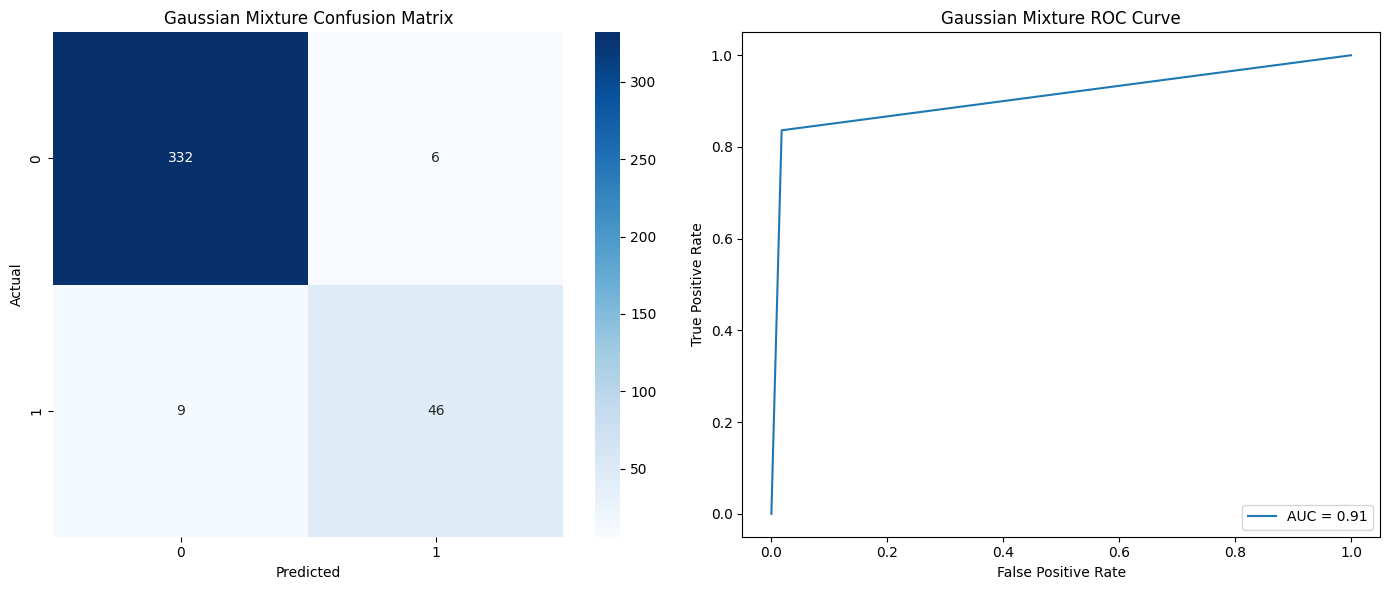

In [73]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test, y_pred_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
auc = roc_auc_score(y_test,y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Gaussian Mixture Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
ax[1].set_title('Gaussian Mixture ROC Curve')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [74]:
results['Gaussian Mixture'] = get_metrics(y_test, y_pred_test)

In [75]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize Gaussian Mixture Model
    gmm = GaussianMixture(n_components=2, random_state=42)
    
    # Fit the model on the training data
    gmm.fit(X_train)
    
    # Predict on the test data
    y_pred = gmm.predict(X_test)
    
    # The GMM labels clusters; we need to convert to anomaly detection
    # Assign the smaller cluster to be anomalies
    labels = gmm.predict(X_train)
    cluster_sizes = np.bincount(labels)
    anomaly_cluster = np.argmin(cluster_sizes)
    y_pred = np.where(gmm.predict(X_test) == anomaly_cluster, 1, 0)
    
    # Evaluate the model
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

# Print evaluation metrics
print(f'Average Accuracy: {average_accuracy:.2f}')
print(f'Average Precision: {average_precision:.2f}')
print(f'Average Recall: {average_recall:.2f}')
print(f'Average F1 Score: {average_f1:.2f}')

Average Accuracy: 0.94
Average Precision: 0.82
Average Recall: 0.71
Average F1 Score: 0.76


In [76]:
resultsCrossVal['Gaussian Mixture Model'].append(get_metrics(y_test, y_pred))

## Autoencoders

# Training Results

In [77]:
results

,Metrics,Isolation Forest,LOF Novelty Detection,Gaussian Mixture
0,True Negatives,317,286,332
1,False Negatives,20,52,6
2,False Positives,5,16,9
3,True Positives,52,39,46
4,Accuracy,0.936548,0.826972,0.961832
5,Precision,0.722222,0.428571,0.884615
6,Recall,0.912281,0.709091,0.836364
7,F1-Score,0.806202,0.534247,0.859813
8,Support,None,None,None


In [206]:
def get_performance_curve(fit_data, predict_data, labels, threshold_range, predict_fn, model=None, model_fn=None, model_args=None):
    recall_list = []
    audit_ratio_list = []

    for i in threshold_range:
        if model == None:
            new_model = fit_model(fit_data, model_fn, model_args, i, labels)
        else:
            new_model = model
        
        y_pred = predict_model(predict_data, new_model, predict_fn, i)

        audit_ratio = sum(pred == 1 for pred in y_pred)/len(y_pred)

        recall_list.append(recall_score(labels, y_pred))
        audit_ratio_list.append(audit_ratio)
    
    performance_curve = pd.DataFrame()
    performance_curve['Audit ratio'] = audit_ratio_list
    performance_curve['Detected frauds ratio'] = recall_list

    return performance_curve.sort_values('Audit ratio')

ideal_curve = pd.DataFrame()
ideal_curve['Audit ratio'] = [0, 0.15, 1]
ideal_curve['Detected frauds ratio'] = [0, 1, 1]

def plot_all_performance_curves(isolation_forest_performance_curve, autoencoder_performance_curve, lof_performance_curve, gm_performance_curve, title):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    plt.title(title)
    plt.xlabel('Audit ratio')
    plt.ylabel('Detected frauds ratio')

    plt.xlim(right=0.5)

    x_ticks = np.arange(0, 0.55, 0.05)
    y_ticks = np.arange(0, 1.1, 0.1)

    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    plt.plot(isolation_forest_performance_curve['Audit ratio'], isolation_forest_performance_curve['Detected frauds ratio'], label='Isolation Forest')
    plt.plot(autoencoder_performance_curve['Audit ratio'], autoencoder_performance_curve['Detected frauds ratio'], label='Autoencoder')
    plt.plot(lof_performance_curve['Audit ratio'], lof_performance_curve['Detected frauds ratio'], label='Local Outlier Factor')
    plt.plot(gm_performance_curve['Audit ratio'], gm_performance_curve['Detected frauds ratio'], label='Gaussian Mixture')
    plt.plot(ideal_curve['Audit ratio'], ideal_curve['Detected frauds ratio'], label='Ideal curve', linestyle='--')
    plt.axvline(0.15, linestyle='--')

    plt.grid(linestyle='--')
    plt.legend()

In [208]:
# Get performance curves with minimal preprocessing
threshold_range = np.logspace(np.log10(0.001), np.log10(0.5))

if_performance_curve_test = get_performance_curve(X_train, X_test, y_test, threshold_range, predict_isolation_forest, model_fn=fit_isolation_forest)
lof_performance_curve_test = get_performance_curve(X_train, X_test, y_test, threshold_range, predict_local_outlier_factor, model_fn=fit_local_outlier_factor, model_args=[20])
gm_curve_test = get_performance_curve(X_train, X_test, y_test, threshold_range, predict_gaussian_mixture, model_fn=fit_gaussian_mixture)
ae_performance_curve_test = get_performance_curve(X_train, X_test, y_test, threshold_range, predict_autoencoder, model_fn=fit_autoencoder, model_args=[0.0001, 300])

# Plot performance curves
plot_all_performance_curves(if_performance_curve_test, ae_performance_curve_test, lof_performance_curve_test, gm_curve_test, 'Performance curve with minimal preprocessing')

TypeError: predict_model() takes 3 positional arguments but 4 were given

# Cross Validation Results

In [86]:
resultsCrossVal

{'Isolation Forest': [array([326, 12, 2, 53, 0.9643765903307888, 0.8153846153846154,
         0.9636363636363636, 0.8833333333333333, None], dtype=object),
  array([326, 12, 2, 53, 0.9643765903307888, 0.8153846153846154,
         0.9636363636363636, 0.8833333333333333, None], dtype=object),
  array([326, 12, 2, 53, 0.9643765903307888, 0.8153846153846154,
         0.9636363636363636, 0.8833333333333333, None], dtype=object)],
 'LOF (Novelty Detection)': [array([319, 19, 32, 23, 0.8702290076335878, 0.5476190476190477,
         0.41818181818181815, 0.4742268041237113, None], dtype=object)],
 'Gaussian Mixture Model': [array([332, 6, 9, 46, 0.9618320610687023, 0.8846153846153846,
         0.8363636363636363, 0.8598130841121495, None], dtype=object)]}

## now we'll do hyperparameter tunning to the best model

In [90]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

# Function to get metrics
def get_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

# Define a smaller parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_samples': ['auto', 0.5],
    'contamination': [0.1, 0.2],
    'max_features': [1.0, 0.5],
    'bootstrap': [True, False]
}

# Initialize Isolation Forest
isolation_forest = IsolationForest(random_state=42)

# Define the scoring function
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1 Score': make_scorer(f1_score)
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=isolation_forest, param_grid=param_grid, scoring=scoring, refit='F1 Score', cv=5, verbose=2, n_jobs=1)

# Fit GridSearchCV
grid_search.fit(X, y)

# Get the best estimator
best_isolation_forest = grid_search.best_estimator_

# Perform k-fold cross-validation with the best estimator
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the best Isolation Forest model
    best_isolation_forest.fit(X_train)
    
    # Predict on the test data
    y_pred = best_isolation_forest.predict(X_test)
    
    # Convert predictions from {-1, 1} to {0, 1}
    y_pred = np.where(y_pred == -1, 1, 0)
    
    # Evaluate the model
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Calculate average metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

# Print evaluation metrics
print(f'Average Accuracy: {average_accuracy:.2f}')
print(f'Average Precision: {average_precision:.2f}')
print(f'Average Recall: {average_recall:.2f}')
print(f'Average F1 Score: {average_f1:.2f}')

# Print best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END bootstrap=True, contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.1s
[CV] EN

# Lets run our test DataFrame